### <p>EMail Spam Classification Using Naive Bayes Approximation.</p><br>

<ol>
<li><p>We will try to create a simple spam filter with the help of naive bayes probability approximation.</p></li>
<li><p>We need to have a high precision score.If we consider Spam mails as positive class then we do not want our HAM mails to be classified as SPAM.</p></li>
<li><p>We will take the top 15k words from our train dataset and will do a binary one hot encoding of mails using count vectorizer.</p></li>
<li><p>Datset Link<a>https://www.kaggle.com/venky73/spam-mails-dataset</a></p></li>
</ol>


In [41]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

import re
import re
from nltk.corpus import stopwords
from nltk import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud

from tqdm import tqdm_notebook as tqdm
from prettytable import PrettyTable
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

In [42]:
dataframe=pd.read_csv('spam.csv')
dataframe.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [43]:
dataframe=dataframe[['text','label_num']]

In [44]:
dataframe1=dataframe.copy()

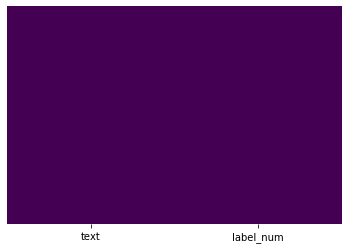

In [45]:
sns.heatmap(dataframe.isnull(),cbar=False,yticklabels=False,cmap='viridis')

### Getting Little insights about the Data

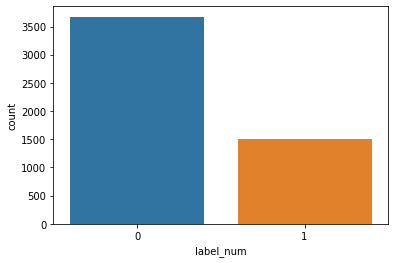

% of ham(0) mails 71.01140978534133
% of Spam(1) emails 28.98859021465867


In [46]:
sns.countplot(data=dataframe,x='label_num')
plt.show()
v=(dataframe[dataframe['label_num']==0].shape[0]/dataframe.shape[0])*100
print("% of ham(0) mails {}\n% of Spam(1) emails {}".format(v,100-v))

## Text Preprocessing

In [47]:
m_spwrd=set(stopwords.words('english'))
m_spwrd.remove('not')
m_spwrd.remove('nor')
m_spwrd.remove('no')

In [48]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [49]:
def FtxtP(phrase):
    phrase=re.sub(r'\r\n',' ',phrase)
    phrase=decontracted(phrase)
    phrase=re.sub(r"[^A-Za-z0-9]",r" ",phrase)
    phrase=phrase.lower()
    phrase=" ".join(w.strip() for w in phrase.split() if w not in m_spwrd).strip()
    #phrase=" ".join(PorterStemmer().stem(w) for w in phrase.split()).strip()
    
    return phrase
    

In [50]:
dataframe['text']=dataframe['text'].apply(func=FtxtP)

#removing the SUBJECT from each mail
dataframe['text']=dataframe['text'].apply(lambda x:" ".join(w.strip() for w in x.split()[1:]).strip())

In [51]:
dataframe.head()

,text,label_num
0,enron methanol meter 988291 follow note gave m...,0
1,hpl nom january 9 2001 see attached file hplno...,0
2,neon retreat ho ho ho around wonderful time ye...,0
3,photoshop windows office cheap main trending a...,1
4,indian springs deal book teco pvr revenue unde...,0


In [52]:
words_sp=""
for mails in dataframe[dataframe['label_num']==1]['text'].values:
    words_sp+=mails+" "
words_sp=words_sp.rstrip()

words_hm=""
for mails in dataframe[dataframe['label_num']==0]['text'].values:
    words_hm+=mails+" "
words_hm=words_hm.rstrip()

In [53]:
m1=np.array(Image.open('msk2.png'))
wcsp=WordCloud(height=400,width=700,background_color='white',mask=m1,colormap='Reds').generate(words_sp)
wchm=WordCloud(height=400,width=700,background_color='white',mask=m1,colormap='summer').generate(words_hm)

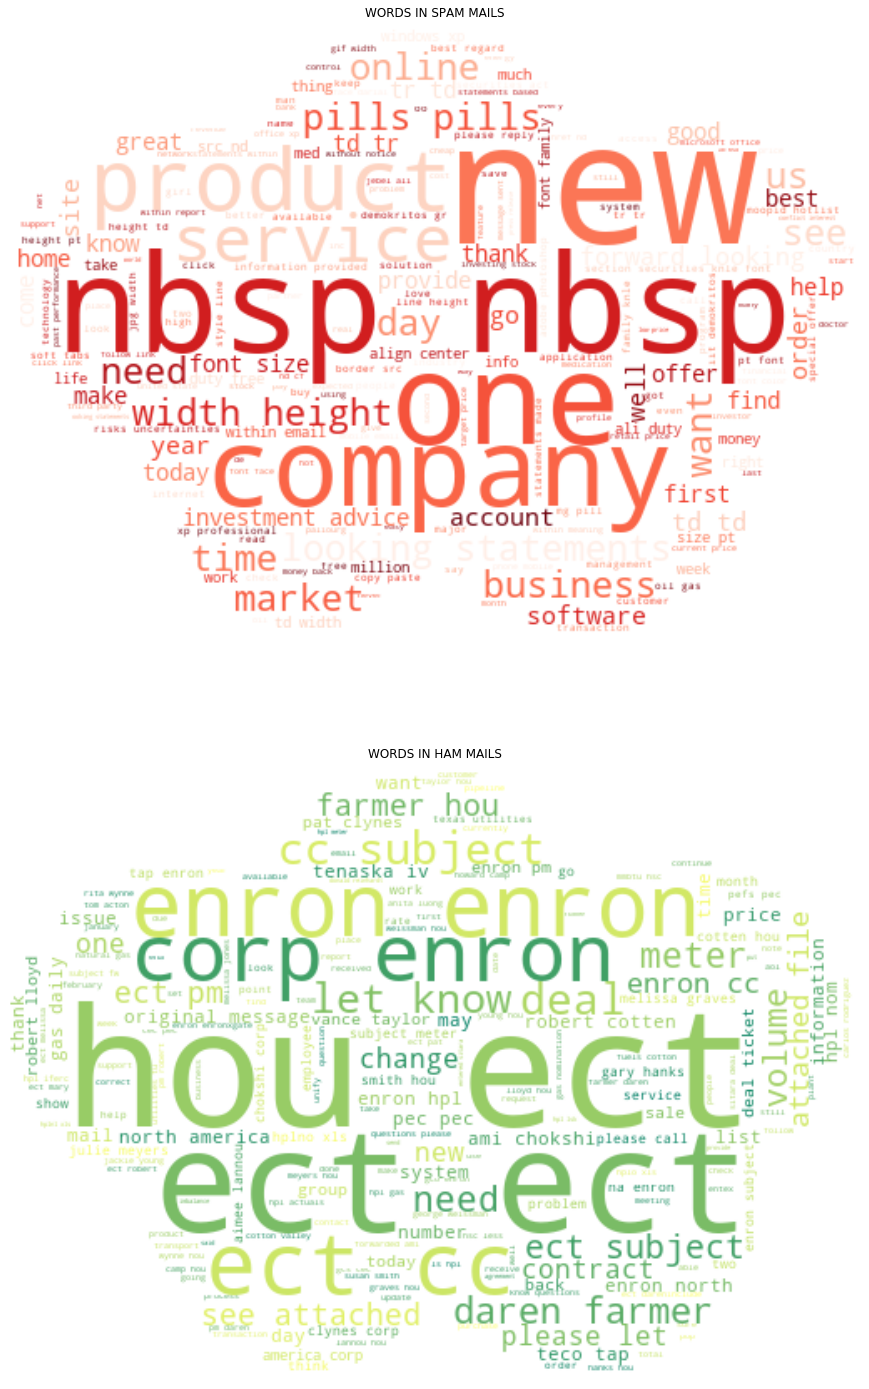

In [54]:
fig,ax=plt.subplots(2,1,figsize=(20,25))
ax[0].imshow(wcsp,interpolation='bilinear')
ax[0].axis("off")
ax[0].set_title('WORDS IN SPAM MAILS')

ax[1].imshow(wchm,interpolation='bilinear')
ax[1].axis("off")
ax[1].set_title('WORDS IN HAM MAILS')
plt.show()

### create a simple naive bayes classifier using count vectorizer only....

In [55]:
d1=dataframe[['text','label_num']]
y=d1['label_num'].values
d1.drop(columns=['label_num'],axis=1,inplace=True)

In [56]:
x_tr1,x_ts1,y_tr1,y_ts1=train_test_split(d1,y,stratify=y,test_size=0.20)

In [57]:
cv=CountVectorizer(binary=False,max_features=15000,min_df=1,lowercase=True,ngram_range=(1,1))
cv.fit(x_tr1.values.ravel())
tr_bow=cv.transform(x_tr1.values.ravel())
ts_bow=cv.transform(x_ts1.values.ravel())


In [58]:
###APPLY naive bayes to create a spam filter....
tr_vec=tr_bow.toarray()
ts_vec=ts_bow.toarray()

### NAIVE BAYES APPROXIMATION TO CALCULATE THE PROBABILITIES

<p>1.We will apply Bayes Approximation to calculate the probabilities P(Y|X) for each class.</p>
<br>
<ul>
<li>P(Y==1|X)= $\begin{align}\frac{P(X|Y==1)P(Y==1)}{P(X)}\end{align}$  (chances that given email is a spam.)</li><br>
<li>P(Y==0|X)= $\begin{align}\frac{P(X|Y==0)P(Y==0)}{P(X)}\end{align}$(chances that given email is not a spam)</li><br></ul>

<p>2.Looking at the likelihood term P(X|Y==1) or P(X|Y==0) we make the naive approximation of independence of the features..</p>
<p>Each of my X represent a vectorized mail of 15000 Dimensions i.e $\begin{align}X\in\{0,1\}^{10000}\end{align}$.So actually my P(X|Y) is P($\begin{align}x_{1},x_{2},x_{3},....x_{9999},x_{10000}\end{align}|Y$). where each of $x_{i}$ represent a word(Unigram) that appear in the mail and it takes value 1 if it is present in the mail and 0 if it is not present in the mail.</p>
<p>We will assume that ocuurance of a given word is independent of the words which appear before it.Simplifying the likelihood term a little more...</p><br>
<p>P(X|Y) = P($\begin{align}x_{1},x_{2},x_{3},....x_{14999},x_{15000}\end{align}|Y$)<br>
P(X|Y)=$\begin{align}P(x_{1}|Y)P(x_{2}|x_{1},Y)P(x_{3}|x_{1},x{2},Y).....P(x_{15000}|x_{1},x_{2},x_{3},....x_{14999},Y)\end{align}$<br>
P(X|Y)=$\begin{align}P(x_{1}|Y)P(x_{2}|Y)P(x_{3}|Y).....P(x_{15000}|Y)\end{align}$<br></p>
<br>
This approximation gives us
$P(X|Y)=\prod_{j=1}^{15000}P(x_{j}|Y)$
<p>Looking at the above expression we can say that we have to find the likelihood of each word $x_{j}$ appearing in a spam(Y=1)and a ham(Y=0) mail.</p>

<h4>3.Modeling/Learning the various parameters.</h4>
<p>As Naive Bayes falls under the Generative Class of Algorithms for Supervised Learning so we have to calculate the class prior P(Y) and the likelihood terms P(X|Y==1),P(X|Y==0) for each class. </p><br>

<p>Lets create the parameters for our model that the model will learn during training..<br><br>
1.$\phi_{j|Y=1}=P(x_{j}=1|Y=1)$.........probability of word $x_{j}$ appearing in the Spam mails.<br>
2.$\phi_{j|Y=0}=P(x_{j}=1|Y=0)$.........probability of word $x_{j}$ appearing in the Ham mails.<br>
3.$\phi_{y}=P(Y=1)$.......probability that the mail is the spam mail.<br>
4.$1-\phi_{y}=P(Y=0)$......probability that the mail is a ham mail.</p>

<p>Maximizing the likelihood of parameters over data and getting the optimal value of parameters.<br><br>
$L(\phi_{x_{j}|Y=1},\phi_{x_{j}|Y=0},\phi_{y})=\prod_{i=1}^{m}P(x^{(i)},y^{(i)})$....m is the total training examples that we are having.</p><br>
<p style="color:red;">**$x^{(i)}$ denote the ith training text and $x_{ji}$ denote the jth word in ith training example.</p>

<p>We get the parameter values after maximizing the likelihood over the training data as (1 and 2 are added to the numerator and denominator as a result of <font size='2.5px' >LAPLACE SMOOTHING</font>;  so that our probability will not be 0)</p><br><br>
<ol>
<li><p style="color:black;font-size:15px">$\phi_{y}=\frac{\sum_{i=1}^{15,000}1[y^{(i)}=1]}{15,000}$ </p></li><br><br>
<li><p style="color:black;font-size:15px">$\phi_{j|y=1}=\frac{\sum_{i=1}^{15,000}1[y^{i}=1\;\wedge\;x_{j}^{(i)}==1]\;+1}{\sum_{i=1}^{15,000}1[y^{i}=1]\;+2}$ ...probability of word $x_{j}$ appearing in the SPAM mail.</p></li><br><br>
<li><p style="color:black;font-size:15px">$\phi_{j|y=0}=\frac{\sum_{i=1}^{15,000}1[y^{i}=0\;\wedge\;x_{j}^{(i)}==1]\;+1}{\sum_{i=1}^{15,000}1[y^{i}=0]\;+2}$ ...probability of word $x_{j}$ appearing in the HAM mail.</p></li><br><br>
</ol>







In [59]:
#PRIOR PROBABILITIES:
Prior_sp=tr_vec[y_tr1==1].shape[0]/y_tr1.shape[0]
Prior_ham=1-Prior_sp

In [60]:
#LIKELIHOOD PROBABILITIES WITH LAPLACE SMOOTHING....
phi_j_spam=[]
phi_j_ham=[]

sp_mails=tr_vec[y_tr1==1]
hm_mails=tr_vec[y_tr1==0]
for j in tqdm(range(tr_vec.shape[1])):
    
    phi_j_spam.append((np.sum(sp_mails[:,j])+1)/(sp_mails.shape[0]+2))
    phi_j_ham.append((np.sum(hm_mails[:,j])+1)/(hm_mails.shape[0]+2))
    
    
    

In [61]:
#To Find The probabilities for the Test data points

pred_sp=[]
pred_hm=[]
for mail in tqdm(ts_vec):
    log_product_spm=np.log(Prior_sp);log_product_ham=np.log(Prior_ham)
    for word in range(mail.shape[0]):
        if mail[word]==1:
            log_product_spm+=np.log(phi_j_spam[word])
            log_product_ham+=np.log(phi_j_ham[word])
            
    pred_sp.append(log_product_spm)
    pred_hm.append(log_product_ham)
    

In [62]:
predicted_labels=[]
for mail in range(len(pred_sp)):
    
    if(pred_sp[mail]>pred_hm[mail]):
        predicted_labels.append(1)
    else:
        predicted_labels.append(0)

In [63]:
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,f1_score
def conf_mtx(matrix):
        plt.figure(figsize=(7,6))
        ax= plt.subplot()
        sns.heatmap(matrix, annot=True, ax = ax,fmt=".3f",cmap='seismic'); #annot=True to annotate cells

        # labels, title and ticks
        ax.set_xlabel('Predicted labels');ax.set_ylabel('Actual labels'); 
        ax.set_title('Confusion Matrix'); 
        ax.xaxis.set_ticklabels(['0', '1']); ax.yaxis.set_ticklabels(['0', '1']);
        plt.show()

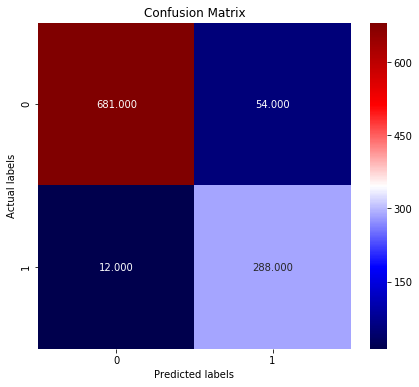

+----------+--------------------+
|  Score   |       Values       |
+----------+--------------------+
| Accuracy | 0.936231884057971  |
| Precison | 0.8421052631578947 |
| f1_score | 0.8971962616822429 |
+----------+--------------------+


In [64]:
conf_mtx(confusion_matrix(y_true=y_ts1,y_pred=predicted_labels))
pt=PrettyTable()
pt.field_names=['Score','Values']
pt.add_row(['Accuracy',accuracy_score(y_true=y_ts1,y_pred=predicted_labels)])
pt.add_row(['Precison',precision_score(y_true=y_ts1,y_pred=predicted_labels)])
pt.add_row(['f1_score',f1_score(y_true=y_ts1,y_pred=predicted_labels)])
print(pt)

### We have acieved a pretty decent score by just doing naive assumption .
#### We can add some more featurizations like mail length. Appearence of multiple punctuations like !,???,....repetition of words like 'buy','drugs' in  spam mails can be a distinguishing property to do featurization.